# common lib

In [63]:
import datetime
import logging
from typing import Callable, Dict, List, Tuple, Union

import numpy as np
import pandas as pd
from dateutil import parser
#from omicron.core.timeframe import tf

logger = logging.getLogger(__name__)

APPROX_BDAYS_PER_YEAR = 252

cols = "成交日期 证券代码 证券名称 操作 成交均价 成交数量 成交金额 fee".split(" ")


def int2date(x):
    if isinstance(x, float):
        x = int(x)

    return parser.parse(str(x)).date()


class NoOpenTradesError(Exception):
    pass


from collections import defaultdict

from dateutil import parser


class Trade:
    LONG = 1
    INTEREST = 2
    SHORT = -1
    DEDUCT = -2
    OTHER = 0

    OPENED = 0
    CLOSED = 1

    def __init__(self, row, i):
        self.seq = i
        self.shares = abs(row["成交数量"])

        self.name = row["证券名称"]
        self.code = row["证券代码"]

        self.price = row["成交均价"]
        self.money = row["成交金额"]
        self.fee = row["fee"]
        self.date = row["成交日期"]

        self.status = self.OPENED
        self.op = row["操作"]

        if self.op.find("卖出") != -1:
            self.flag = self.SHORT
        elif self.op.find("买入") != -1:
            self.flag = self.LONG
        elif self.op in ("红股派息", "债券兑息"):
            self.flag = self.INTEREST
            self.status = self.CLOSED
        elif self.op.find("扣款") != -1:
            self.flag = self.DEDUCT
            self.status = self.CLOSED
        else:
            self.flag = self.OTHER

        # only for LONG trades
        if self.flag == self.LONG:
            self.unsell = self.shares

            self._profit = 0
            self.holding_days = 0

    def sell(self, shares, price, fee, close_dt):
        """从当前未售出股中售出。

        计算时将根据售出的股数，分摊买入和卖的交易成本。返回未售出的股份和未分摊的成本。
        """
        assert self.flag == self.LONG

        if self.status != self.CLOSED:
            assert (
                self.unsell > 0
            ), f"{self.name}, {self.unsell}, {self.status}, {self.shares}"

            sellable = min(shares, self.unsell)

            # 计算本次交易的收益，并分摊交易成本
            amortized_buy_fee = self.fee * sellable / self.shares
            amortized_sell_fee = fee * sellable / shares

            self._profit += (
                sellable * (price - self.price) - amortized_buy_fee - amortized_sell_fee
            )

            # 持仓日期, 可转债交易和做T会出现持仓日期为0的情况。持仓日期为零为使得年化收益成为
            # 正负无穷。为简单起见，设置最低持仓天数为1
            holding_days = max(1, (close_dt - self.date).days)
            #holding_days = max(1, tf.count_day_frames(self.date, close_dt))
            self.holding_days += holding_days * sellable / self.shares

            # 调整可卖股数
            self.unsell -= sellable
            if self.unsell == 0:
                self.status = self.CLOSED

            return shares - sellable, fee - amortized_sell_fee

    @property
    def profit(self):
        assert self.flag == self.LONG
        return self._profit

    @property
    def percentage_profit(self):
        assert self.flag == self.LONG
        return self._profit / (self.shares * self.price)

    @property
    def closed(self):
        return self.status == self.CLOSED

    @closed.setter
    def closed(self, value):
        self.status = self.CLOSED if value else self.OPENED

    def __str__(self):
        return f"{self.name}[{self.code}]: {self.op}\n成交股数：{self.shares}\n成交均价：{self.price}\n成交金额：{self.money}\n成交日期：{self.date}\n"

    def __repr__(self) -> str:
        return self.__str__()


class Evaluator:
    def __init__(self,name: str, file: str, preprocessor: Callable) -> None:
        self.name = name
        self.file = file
        self.preprocessor = preprocessor
        self.range = None
        self.df = None
        self.returns = None

        self.unpaired_long = []
        self.unpaired_short = []

    def read_bill(self):
        df = self.preprocessor(self.file)
        
        missed_fields = set(cols) - set(df.columns)
        if len(missed_fields):
            raise AssertionError(f"缺少这些字段:{missed_fields}")
        
        try:
            df["证券代码"] = [
                f"{int(code):06}" if not np.isnan(code) else "" for code in df["证券代码"]
            ]
        except:
            pass

        self.df = df.sort_values("成交日期", ascending=True)
        self.df.reset_index(inplace=True)
        self.range = (self.df.iloc[0]["成交日期"].date(), self.df.iloc[-1]["成交日期"].date())
        
        long = defaultdict(list)
        short = defaultdict(list)

        skipped = []
        for index, row in self.df.iterrows():
            trade = Trade(row, index)

            if trade.flag == Trade.LONG:
                long[trade.code].append(trade)
            elif trade.flag == Trade.SHORT:
                short[trade.code].append(trade)
            else:
                skipped.append(index)
        return long, short, self.df, skipped

    def close_transactions(self, long_trades, short_trades):
        for code, _long_trades in long_trades.items():
            i = 0
            if short_trades.get(code) is None:
                continue

            try:
                for short in short_trades.get(code):
                    sellable, price, fee, close_dt = (
                        short.shares,
                        short.price,
                        short.fee,
                        short.date,
                    )

                    while sellable > 0:
                        while _long_trades[i].closed:
                            i += 1
                            if i >= len(_long_trades):
                                raise NoOpenTradesError

                        long = _long_trades[i]
                        sellable, fee = long.sell(sellable, price, fee, close_dt)
                    
                    short.closed = True
            except NoOpenTradesError:
                pass

        returns = []
        for code, trades in long_trades.items():
            for t in trades:
                if t.profit != 0:
                    returns.append((t.date, t.name, t.profit, t.percentage_profit, t.holding_days))
                if not t.closed:
                    self.unpaired_long.append(t)

        for code, trades in short_trades.items():
            for t in trades:
                if not t.closed:
                    self.unpaired_short.append(t)

        returns = pd.DataFrame(
            returns, columns=["date", "name", "profit", "pprofit", "days"]
        )
        returns["daily_pprofit"] = returns["pprofit"] / returns["days"]

        self.returns = returns.sort_values("date")
        
    def report(self):
        total_profit = sum(self.returns.profit.values)
        average_holding_days = np.mean(self.returns.days)

        print(f"\n====== {self.name} 交易评估报告 ======")
        print("交易次数", len(self.returns))
        print("操作区间", self.range[0], '-', self.range[-1])
        print("总利润:", round(total_profit, 2))
        print("持仓天数:", round(average_holding_days, 2))
        print("\n亏损最多:\n", self.returns.nsmallest(3, "pprofit"))
        print("盈利最多:\n", self.returns.nlargest(3, "pprofit"))
        print(f"笔均利润: {self.returns.pprofit.mean():.1%}")
        print(f"利润中位数: {self.returns.pprofit.median():.1%}")

        wr = len(self.returns[self.returns.profit > 0]) / len(self.returns)
        print(f"交易胜率: {wr:.2%}")

        print(" ------ ")
        print("未配对交易:")
        data = []
        for t in self.unpaired_long:
            data.append(("买入", t.date, t.name, t.code, t.shares, t.price, t.fee))

        for t in self.unpaired_short:
            data.append(("卖出", t.date, t.name, t.code, t.shares, t.price, t.fee))

        print(pd.DataFrame(data, columns=["操作", "日期", "名称", "代码", "股数", "价格", "手续费"]))

        plt.figure(figsize=(12, 6), dpi=80)
        plt.plot(self.returns["date"], np.cumsum(self.returns.profit.values))
        plt.title("资产收益曲线")

    def check(self):
        long_trades, short_trades, df, skipped = self.read_bill()

        print("操作区间：", df.iloc[0]["成交日期"].date(), "~", df.iloc[-1]["成交日期"].date())

        skipped_df = df.iloc[skipped]

        print("未处理交易笔数：", len(skipped_df))
        print("未处理交易类型：", " ".join(skipped_df["操作"].unique()))
        
        llong = sum([len(trades) for trades in long_trades.values()])
        lshort = sum([len(trades) for trades in short_trades.values()])
        
        print("\n买入笔数:", llong)
        print("卖出笔数:", lshort)

        print("\n交易记录摘要:")
        print(df[:10])

    def run(self):
        long, short, _, _ = self.read_bill()

        self.close_transactions(long, short)
        self.report()

    def preprocessor(self, file: str) -> pd.DataFrame:
        pass


In [18]:
home = "/Users/aaronyang/Documents/business/格物致知/团队/简历"

def get_file(name, filename):
    return os.path.join(home, name, filename)

# 黄芬


====== 黄芬 交易评估报告 ======
交易次数 607
操作区间 2020-03-02 - 2022-01-28
总利润: 114127.49
持仓天数: 8.33
夏普率: 0.63
索提诺比率: 0.94
交易胜率: 55.19%
 ------ 
未配对交易:
    操作         日期    名称      代码    股数      价格    手续费
0   买入 2021-11-16  江苏索普  600746  3700   13.17   8.28
1   买入 2022-01-14  江苏索普  600746  3200   15.47   8.42
2   买入 2022-01-18  江苏索普  600746  8700   15.33  22.68
3   买入 2022-01-20  江苏索普  600746  3500   14.03   8.35
4   买入 2022-01-21  江苏索普  600746  3600   13.70   8.39
5   买入 2022-01-28  江苏索普  600746  2600   13.03   5.76
6   买入 2021-11-08   玉禾田  300815  1200   31.47   5.66
7   买入 2021-11-10   玉禾田  300815  1600   30.29   7.27
8   买入 2022-01-14   玉禾田  300815  1600   29.98   7.20
9   卖出 2021-01-08  一鸣食品  605179  1000   23.35  28.82
10  卖出 2021-02-08  南网能源  003035   500    7.65   8.83
11  卖出 2021-09-29  中远海控  601919   600   16.66  15.20
12  卖出 2021-08-06  康泰转2  123119    10  137.96   0.28


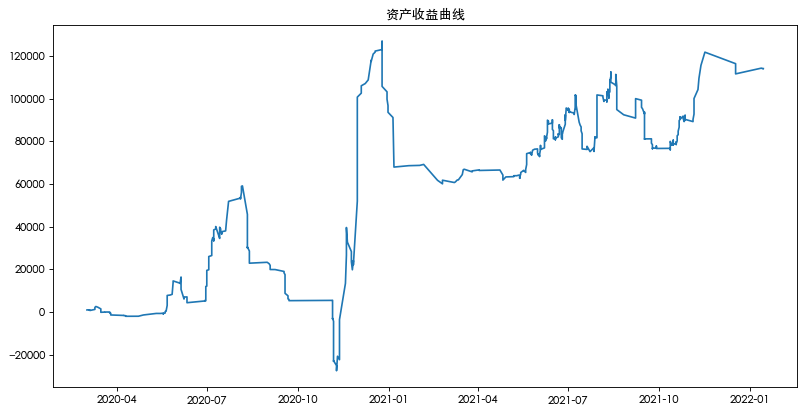

In [201]:
def preprocess_hf(f)->pd.DataFrame:
    return pd.read_excel(f, parse_dates=["成交日期"])

name = "黄芬"
file = os.path.join(home, name, "交易数据黄芬.xlsx")
e = Evaluator(name, file, preprocess_hf)
e.run()

# 张恒

In [294]:
df = pd.read_csv("/tmp/zh.xls", encoding="gbk", sep="\t")

,买入日期,证券代码,证券名称,操作,成交均价,成交数量,成交金额,手续费,Unnamed: 8,卖出日期,证券代码.1,证券名称.1,操作.1,成交均价.1,成交数量.1,成交金额.1,手续费.1,印花税,过户费
0,20210730,301031,中熔电气,证券买入,179.52,900,161568,50.09,NaN,20210730.0,300040.0,九洲集团,证券卖出,8.76,2300.0,20148.0,6.25,20.15,0.0


In [206]:
def preprocess_zh(f)->pd.DataFrame:
    df = pd.read_csv(f, sep="\t", encoding="gbk")
    data = []
    
    for _, r in df.iterrows():
        buy_fields = "买入日期 证券代码 证券名称 操作 成交均价 成交数量 成交金额 手续费"
        values = [r[k] for k in buy_fields.split(" ")]
        # 印花税 手续费
        values.extend([0, 0])
        
        data.append(values)
        sell_fields = "卖出日期 证券代码.1 证券名称.1 操作.1 成交均价.1 成交数量.1 成交金额.1 手续费.1 印花税 过户费"
        values = [r[k] for k in sell_fields.split(" ")]
        if np.isnan(values[0]):
            continue
        data.append(values)
        
    cols = "成交日期 证券代码 证券名称 操作 成交均价 成交数量 成交金额 手续费 印花税 过户费"
    df = pd.DataFrame(data, columns=cols.split(" "))
    df["成交日期"] = [int2date(x) for x in df["成交日期"].values]
    
    return df

file = os.path.join(home, "张恒", "zh.xls")
e = Evaluator("张恒", file, preprocess_zh)
e.run()

AttributeError: 'datetime.date' object has no attribute 'date'

# 向光华

In [219]:
def preprocess_xgh(file):
    print("file: ", file)
    df = pd.read_csv(file, encoding='gbk', sep="\t", parse_dates=["成交日期"])

    return df

name = "向光华"
file = get_file(name)
e = Evaluator(name, file, preprocess_xgh)
e.run()

file:  /Users/aaronyang/Documents/business/格物致知/团队/简历/向光华/records.xlsx


UnicodeDecodeError: 'gbk' codec can't decode byte 0xa2 in position 50: illegal multibyte sequence

# 程武

In [208]:
def preprocess_cw(file):
    with open(file) as f:
        lines = f.readlines()
    
    data = []
    for line in lines:
        line = line.strip()
        if len(line) == 0:
            continue
        line = line.replace("   = ", " ").replace("   ", " ")
        data.append(",".join(line.split(" ")))
        
    import io
    stream = io.StringIO("\n".join(data))
    df = pd.read_csv(stream, parse_dates=["成交日期"])
    
    df.rename({
        "委托方向": "操作",
        "交易规费": "其它杂费"
    }, inplace=True, axis="columns")
    
    return df


====== 程武 交易评估报告 ======
交易次数 52
操作区间 2021-11-10 - 2022-01-20
总利润: 21155.27
持仓天数: 1.6
夏普率: 1.73
索提诺比率: 3.42
交易胜率: 40.38%
 ------ 
未配对交易:
   操作         日期    名称      代码    股数     价格   手续费
0  买入 2022-01-20  迦南科技  300412  1900  20.51  3.46
1  卖出 2021-11-10  双杰电气  300444  1000   7.50  8.17


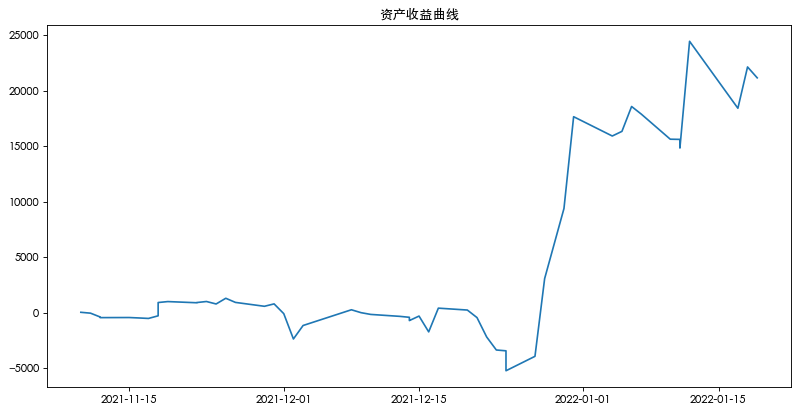

In [216]:
name = "程武"
file = get_file(name)
e = Evaluator(name, file, preprocess_cw)
e.run()

# 高述彪

In [373]:
def preprocess_gxb(file):
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["建仓日期"])
    df.rename({
        "持股天数":"days", 
        "盈亏比例(%)":"pprofit",
        "建仓日期":"date",
        "总盈亏":"profit",
    },axis="columns", inplace=True)
    
    df["daily_pprofit"] = df["pprofit"]/df["days"]/100
    return df

总利润: -15083.47
持仓天数: 7.97
夏普率: 2.08
索提诺比率: 4.39
交易胜率: 53.85%
首次交易： 2021-02-04 00:00:00
最后交易： 2022-02-09 00:00:00


/Users/aaronyang/miniforge3/envs/alpha/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


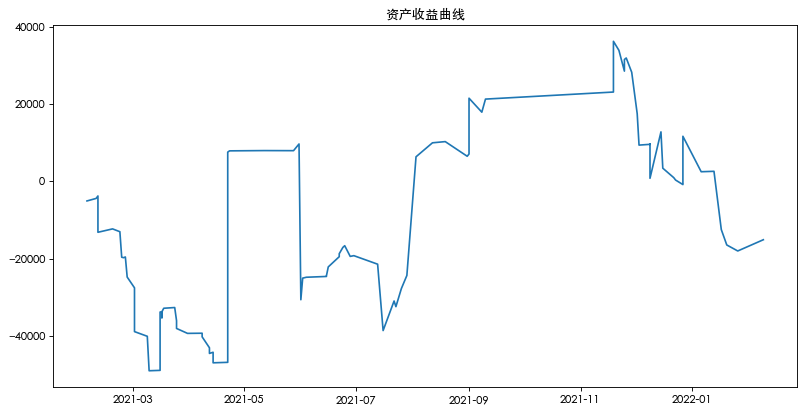

In [374]:
file = f"/tmp/table-1.xls"
returns = preprocess_gxb(file)
df = report(returns[["date", "days", "profit", "pprofit", "daily_pprofit"]])

# 王聪

In [ ]:
等待交割单。截屏已有

# 毛西凉

In [232]:
pd.read_excel("/tmp/mxl.xlsx")[:5]

,成交日期,成交时间,证券代码,证券名称,操作,成交数量,成交编号,成交均价,成交金额,余额,发生金额,手续费,印花税,本次金额,合同编号,股东帐户,过户费,交易市场
0,20200702,11:26:12,603289,泰瑞机器,证券卖出,400,13344490,10.02,4008.0,1200,3998.91,5.0,4.01,4193.83,97095918,A539261728,0.08,上海Ａ股
1,20200703,15:00:00,72838,道恩发债,配售中签,10,5863882337,100.00,0.0,0,0.00,0.0,0.00,0.00,PDZZQF6K,206016680,0.00,深圳Ａ股
2,20200703,09:47:09,603289,泰瑞机器,证券卖出,1200,5553856,10.12,12144.0,0,12126.62,5.0,12.14,12620.45,97185443,A539261728,0.24,上海Ａ股
3,20200703,09:47:44,2187,广百股份,证券买入,1000,10100000710,11.40,11400.0,1000,-11405.00,5.0,0.00,1215.45,PDZZRL8G,206016680,0.00,深圳Ａ股
4,20200703,09:51:54,2187,广百股份,证券买入,100,10100000810,11.14,1114.0,1100,-1119.00,5.0,0.00,96.45,PDZZRMKK,206016680,0.00,深圳Ａ股


总利润: 1422.59
持仓天数: 3.68
夏普率: -1.15
索提诺比率: -1.89
首次交易： 2020-07-03 00:00:00
最后交易： 2020-12-23 00:00:00


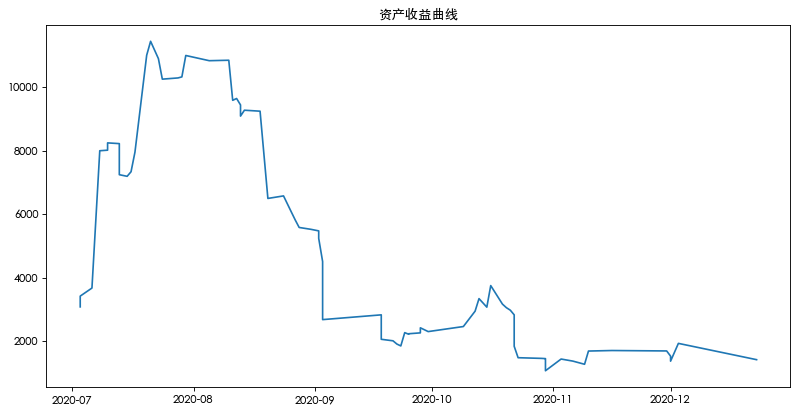

In [366]:
def preprocessor_mxl(file):
    df = pd.read_excel(file)
    df["成交日期"] = df["成交日期"].apply(lambda x: parser.parse(str(x)))
    return df

df = evaluate("/tmp/mxl.xlsx", preprocessor_mxl)

# 刘彬

总利润: -11596.16
持仓天数: 1.4
夏普率: -2.01
索提诺比率: -2.56
交易胜率: 44.87%
首次交易： 2021-07-21 00:00:00
最后交易： 2021-08-20 00:00:00


,date,name,profit,pprofit,days,daily_pprofit
0,2021-07-21,金枫酒业,-250.840000,-0.051339,1.0,-0.051339
1,2021-07-21,江特电机,893.640000,0.209039,2.0,0.104519
20,2021-07-21,远兴能源,-247.386667,-0.075239,1.0,-0.075239
18,2021-07-21,三安光电,-55.800000,-0.015085,1.0,-0.015085
17,2021-07-21,北方稀土,75.920000,0.019618,1.0,0.019618
...,...,...,...,...,...,...
151,2021-08-19,兴业证券,-28.460000,-0.008524,1.0,-0.008524
153,2021-08-19,东方证券,-311.964000,-0.060954,1.0,-0.060954
154,2021-08-19,东方证券,-209.566000,-0.061420,1.0,-0.061420
108,2021-08-20,金辰股份,-427.580000,-0.029308,1.0,-0.029308


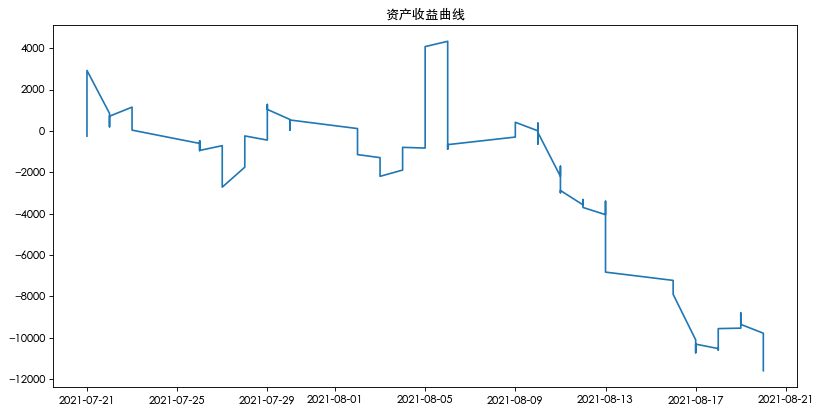

In [78]:
cols = "成交日期 证券代码 证券名称 操作 成交均价 成交数量 成交金额 手续费 印花税 过户费 其它杂费"
def preprocess_lb(file):
    from io import StringIO
    with open(file, encoding="gbk") as f:
        data = []
        for line in f.readlines():
            fields = line.strip().replace("=","").replace('"', "").split("\t")
            data.append("\t".join(fields))
            
    data = "\n".join(data)
    df = pd.read_csv(StringIO(data), sep="\t", parse_dates=["发生日期"])
    df = df[(df['业务名称'] == "证券买入") | (df['业务名称'] == "证券卖出")]
    
    df.rename({"发生日期":"成交日期", "买卖标志": "操作", "成交价格": "成交均价"}, axis="columns", inplace=True)
    fee = []
    for i in range(len(df)):
        if df.iloc[i]["业务名称"] == "证券买入":
            fee.append((df.iloc[i]["清算金额"] + df.iloc[i]["成交金额"]) *-1)
        else:
            fee.append(df.iloc[i]["清算金额"] - df.iloc[i]["成交金额"])
            
    df["手续费"] = np.abs(fee)
    df["成交数量"] = np.abs(df["成交数量"])
    return df

evaluate("/tmp/lb.xls", preprocess_lb)


In [99]:
preprocess_lb("/tmp/lb.xls")

,成交日期,成交时间,申请编号,证券代码,证券名称,操作,成交均价,成交数量,成交金额,清算金额,委托编号,业务名称,股东代码,资金帐号,客户代码,股东姓名,交易所名称,备注,手续费
2,2021-07-21,09:30:05,337,600616,金枫酒业,买入,9.772,500.0,4886.0,-4891.10,337,证券买入,A258168978,880000745763,880000754693,易春燕,上海A股,证券买入,5.10
3,2021-07-21,09:31:25,587,2176,江特电机,买入,14.250,300.0,4275.0,-4280.00,587,证券买入,0182716270,880000745763,880000754693,易春燕,深圳A股,证券买入,5.00
4,2021-07-21,09:32:19,674,2411,延安必康,卖出,9.000,500.0,4500.0,4490.50,674,证券卖出,0182716270,880000745763,880000754693,易春燕,深圳A股,证券卖出,9.50
5,2021-07-21,09:36:39,1039,155,川能动力,卖出,19.464,500.0,9732.0,9712.54,1039,证券卖出,0182716270,880000745763,880000754693,易春燕,深圳A股,证券卖出,19.46
6,2021-07-21,09:36:51,1055,2192,融捷股份,买入,117.800,100.0,11780.0,-11791.78,1055,证券买入,0182716270,880000745763,880000754693,易春燕,深圳A股,证券买入,11.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,2021-08-20,10:24:30,3965,155,川能动力,买入,28.470,200.0,5694.0,-5699.69,3965,证券买入,0182716270,880000745763,880000754693,易春燕,深圳A股,证券买入,5.69
345,2021-08-20,10:33:10,2324,2610,爱康科技,买入,3.140,1000.0,3140.0,-3145.00,2324,证券买入,0182716270,880000745763,880000754693,易春燕,深圳A股,证券买入,5.00
346,2021-08-20,10:44:53,4456,2610,爱康科技,买入,3.140,1000.0,3140.0,-3145.00,4456,证券买入,0182716270,880000745763,880000754693,易春燕,深圳A股,证券买入,5.00
347,2021-08-20,10:46:44,2792,603396,金辰股份,买入,145.890,100.0,14589.0,-14603.88,2792,证券买入,A258168978,880000745763,880000754693,易春燕,上海A股,证券买入,14.88


In [113]:
df = preprocess_lb("/tmp/lb.xls")
df

,成交日期,成交时间,申请编号,证券代码,证券名称,操作,成交均价,成交数量,成交金额,清算金额,委托编号,业务名称,股东代码,资金帐号,客户代码,股东姓名,交易所名称,备注,手续费
2,2021-07-21,09:30:05,337,600616,金枫酒业,买入,9.772,500.0,4886.0,-4891.10,337,证券买入,A258168978,880000745763,880000754693,易春燕,上海A股,证券买入,5.10
3,2021-07-21,09:31:25,587,2176,江特电机,买入,14.250,300.0,4275.0,-4280.00,587,证券买入,0182716270,880000745763,880000754693,易春燕,深圳A股,证券买入,5.00
4,2021-07-21,09:32:19,674,2411,延安必康,卖出,9.000,500.0,4500.0,4490.50,674,证券卖出,0182716270,880000745763,880000754693,易春燕,深圳A股,证券卖出,9.50
5,2021-07-21,09:36:39,1039,155,川能动力,卖出,19.464,500.0,9732.0,9712.54,1039,证券卖出,0182716270,880000745763,880000754693,易春燕,深圳A股,证券卖出,19.46
6,2021-07-21,09:36:51,1055,2192,融捷股份,买入,117.800,100.0,11780.0,-11791.78,1055,证券买入,0182716270,880000745763,880000754693,易春燕,深圳A股,证券买入,11.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,2021-08-20,10:24:30,3965,155,川能动力,买入,28.470,200.0,5694.0,-5699.69,3965,证券买入,0182716270,880000745763,880000754693,易春燕,深圳A股,证券买入,5.69
345,2021-08-20,10:33:10,2324,2610,爱康科技,买入,3.140,1000.0,3140.0,-3145.00,2324,证券买入,0182716270,880000745763,880000754693,易春燕,深圳A股,证券买入,5.00
346,2021-08-20,10:44:53,4456,2610,爱康科技,买入,3.140,1000.0,3140.0,-3145.00,4456,证券买入,0182716270,880000745763,880000754693,易春燕,深圳A股,证券买入,5.00
347,2021-08-20,10:46:44,2792,603396,金辰股份,买入,145.890,100.0,14589.0,-14603.88,2792,证券买入,A258168978,880000745763,880000754693,易春燕,上海A股,证券买入,14.88


# 陶陶

In [223]:
def preprocess_500(file):
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["发生日期"])
    df.rename({"发生日期":"成交日期", "交易类别":"操作"}, inplace=True, axis="columns")
    df["证券代码"] = df["证券代码"].str.replace("= ", "")
    return df

e = Evaluator("陶陶", "/tmp/5002.xls", preprocess_500)


====== 陶陶 交易评估报告 ======
交易次数 131
操作区间 2021-11-23 - 2022-02-22
总利润: -200063.8
持仓天数: 6.91
夏普率: -2.61
索提诺比率: -2.76
交易胜率: 50.38%
 ------ 
未配对交易:
    操作         日期    名称        代码      股数      价格     手续费
0   买入 2022-02-22  长飞光纤  "601869"    1000  30.960    5.62
1   买入 2022-02-22  长飞光纤  "601869"    1000  31.070    5.61
2   买入 2022-02-22  长飞光纤  "601869"     700  31.090    5.43
3   买入 2021-11-23  紫晶存储  "688086"    3740  25.150   13.17
4   买入 2022-02-21  东方国信  "300166"    3200  15.315    5.88
5   买入 2022-02-21  东方国信  "300166"    3100  15.340    5.71
6   买入 2022-02-22  东方国信  "300166"    2500  15.110    5.00
7   买入 2022-02-10  德尔股份  "300473"    2400  21.850    6.29
8   买入 2022-02-08  耀皮玻璃  "600819"  100500   5.400   75.93
9   买入 2022-02-16  耀皮玻璃  "600819"   10400   5.390    7.83
10  买入 2022-02-18  耀皮玻璃  "600819"   10000   5.420    7.59
11  买入 2022-02-22  耀皮玻璃  "600819"   19200   5.350   14.38
12  买入 2022-01-28  惠伦晶体  "300460"    9500  16.520   18.83
13  买入 2022-02-22  申菱环境  "301018"    2000  29.

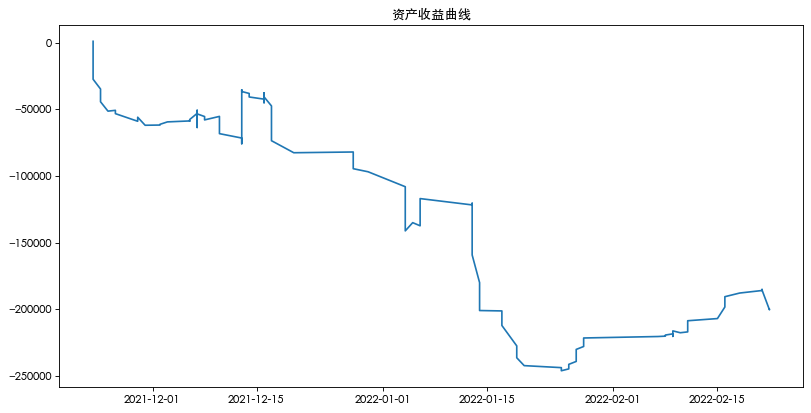

In [224]:
e.run()

# 赵波

In [295]:
def preprocess_zb(file) -> pd.DataFrame:
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["成交日期"])
    df.rename({"成交价格": "成交均价", "委托类别": "操作"}, axis="columns", inplace=True)
    return df

def preprocess_zb02(file) -> pd.DataFrame:
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["交割日期"])
    df.rename(
        {"成交价格": "成交均价", "业务类型": "操作", "交割日期": "成交日期"}, axis="columns", inplace=True
    )

# e = Evaluator("赵波", "/tmp/zb.txt", preprocess_zb)
# e.run()

# e = Evaluator("赵波", "/tmp/zb2.txt", preprocess_zb2)
# e.run()

# e = Evaluator("赵波", "/tmp/zb3.txt", preprocess_zb2)
# e.run()

preprocess_zb(home + "/赵波/交割单查询.txt")

,成交日期,成交时间,股东账户,证券代码,证券名称,操作,成交均价,成交数量,成交金额,发生金额,佣金,印花税,过户费,其他费,成交编号
0,2021-05-07,14:56:36,281363028,2331,皖通科技,卖出,13.18,600,7908,7895.09,5.00,7.91,0.00,0,103000035043127
1,2021-05-07,15:00:00,A680027658,600318,新力金融,买入,6.70,1200,8040,-8045.16,5.00,0.00,0.16,0,27967982
2,2021-05-10,09:36:39,A680027658,600318,新力金融,卖出,6.72,1200,8064,8050.78,5.00,8.06,0.16,0,2868120
3,2021-05-10,09:41:26,281363028,983,山西焦煤,买入,7.35,1100,8085,-8090.00,5.00,0.00,0.00,0,102000005294511
4,2021-05-11,14:48:20,281363028,983,山西焦煤,卖出,7.68,1100,8448,8434.55,5.00,8.45,0.00,0,104000039050484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2021-07-12,09:50:06,281363028,2340,格林美,卖出,11.94,2600,31044,31005.20,7.76,31.04,0.00,0,101000011313330
120,2021-07-12,11:28:10,281363028,504,南华生物,买入,22.10,1400,30940,-30947.74,7.74,0.00,0.00,0,102000029389623
121,2021-07-13,10:21:58,281363028,504,南华生物,卖出,21.80,1400,30520,30481.85,7.63,30.52,0.00,0,102000019922055
122,2021-07-13,11:17:31,A680027658,601882,海天精工,买入,18.69,1600,29904,-29912.08,7.48,0.00,0.60,0,18339714


# 赵成勇


====== 赵成勇 交易评估报告 ======
交易次数 92
操作区间 2021-06-24 - 2021-12-01
总利润: 93953.75
持仓天数: 8.33

亏损最多:
          date  name       profit   pprofit  days  daily_pprofit
24 2021-09-14   利德曼 -5822.000000 -0.129806  13.0      -0.009985
3  2021-07-14  新元科技 -2313.662353 -0.098706  12.0      -0.008225
10 2021-07-27  纳川股份 -2133.550000 -0.091884   1.0      -0.091884
盈利最多:
          date  name        profit   pprofit       days  daily_pprofit
80 2021-11-17  众生药业  10235.078421  0.346154  11.531250       0.030019
63 2021-10-18  沐邦高科  17718.810000  0.334002   7.800000       0.042821
81 2021-11-22  众生药业   5162.358246  0.325475   7.588235       0.042892
笔均利润: 2.3%
利润中位数: -0.7%
交易胜率: 45.65%
 ------ 
未配对交易:
   操作         日期    名称      代码     股数      价格    手续费
0  买入 2021-11-29  雄帝科技  300546   5000  17.138  24.01
1  买入 2021-12-01   爱迪尔  002740  20000   4.350  24.36
2  买入 2021-12-01  宜宾纸业  600793   5500  14.690  25.86
3  卖出 2021-06-25  三峡能源  600905   1000   7.090  12.23
4  卖出 2021-06-30  浙文影业  601599  13600   3.2

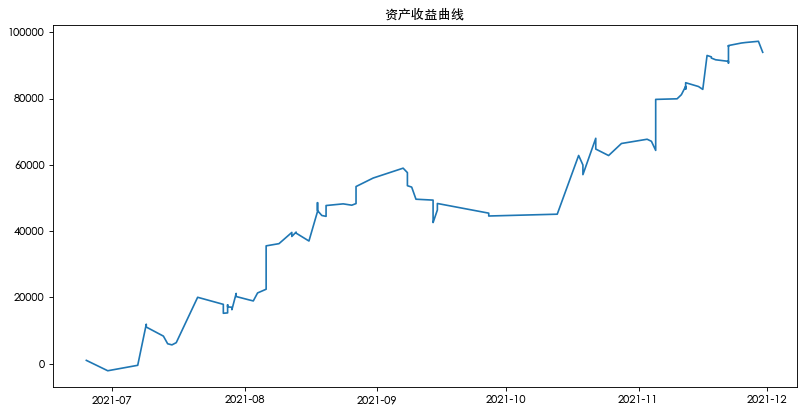

In [64]:
def preprocess_zcy(file):
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["成交日期"])
    
    df["fee"] = df["佣金"] + df["过户费"] + df["经手费"] + df["证管费"] + df["印花税"] + df["其他杂费"]
    return df

file = get_file("赵成勇", "zcy.xls")
e = Evaluator("赵成勇", file, preprocess_zcy)
#e.check()
e.run()

In [54]:
df = preprocess_zcy(file)

In [55]:
df.rename({
    "成交日期":"date",
    "证券代码":"code",
    "证券名称":"name",
    "操作":"side",
    "成交数量":"volume",
    "成交均价":"price",
    "成交金额":"amount",
}, axis='columns', inplace=True)

In [56]:
cols = ["date", "code", "name", "side", "volume", "amount", "fee"]
df2 = df[(df["side"] == "证券买入") | (df["side"] == "证券卖出")][cols]

In [57]:
df2["side"] = df2.side.map(lambda x: 1 if x == "证券买入" else -1)

In [61]:
df2[2:8]

,date,code,name,side,volume,amount,fee
4,2021-06-30,601599,浙文影业,-1,-13600,44064.0,58.16
5,2021-06-30,600035,楚天高速,1,29900,89700.0,28.71
8,2021-07-06,300555,路通视信,-1,-3500,33120.0,42.40
9,2021-07-06,300505,川金诺,-1,-1200,28320.0,36.25
10,2021-07-07,300472,新元科技,1,3000,30480.0,8.53
11,2021-07-08,600035,楚天高速,-1,-29900,86710.0,114.47


# 柴寅


====== 柴寅 交易评估报告 ======
交易次数 121
操作区间 2020-09-10 - 2022-01-18
总利润: 44813.25
持仓天数: 22.22

亏损最多:
          date  name     profit   pprofit   days  daily_pprofit
59 2021-03-08   同花顺 -5087.5950 -0.202161  129.0      -0.001567
61 2021-03-10   同花顺 -4504.0350 -0.184244  127.0      -0.001451
94 2021-06-04  中国平安 -3851.5225 -0.181308   41.0      -0.004422
盈利最多:
          date  name       profit   pprofit  days  daily_pprofit
66 2021-07-19   同花顺  3802.485714  0.191948  99.0       0.001939
48 2021-01-08  三全食品  3866.115714  0.191544  14.0       0.013682
71 2021-10-27   同花顺  4239.315000  0.180781  52.5       0.003443
笔均利润: 1.6%
利润中位数: 1.7%
交易胜率: 68.60%
 ------ 
未配对交易:
    操作         日期    名称          代码    股数      价格    手续费
0   买入 2021-12-16  珠江啤酒  = "002461"  4500    9.16   2.53
1   买入 2021-12-16  珠江啤酒  = "002461"  3400    9.16   2.24
2   买入 2021-12-17  珠江啤酒  = "002461"  3800    9.13   2.10
3   买入 2021-12-17  珠江啤酒  = "002461"  2100    9.14   3.31
4   买入 2021-12-20  珠江啤酒  = "002461"  3000    9.03  

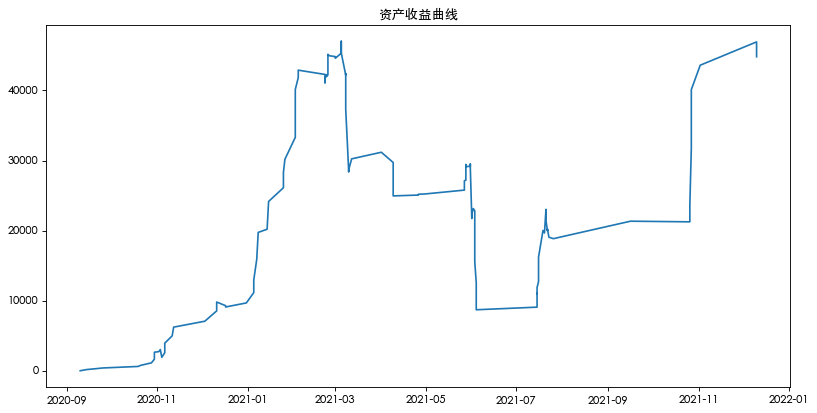

In [89]:
file = "/Users/aaronyang/Documents/business/格物致知/团队/简历/柴寅/20.9.1-20.11.1.xls"

files = ["20.9.1-20.11.1.xls", "20.11.1-21.2.1.xls",
 "21.2.1-21.5.1.xls", "21.5.1-21.8.1.xls", "21.8.1-21.11.1.xls","21.11.1-22.2.1.xls"]

#files = ["21.2.1-21.5.1.xls"]

def preprocess_cy(files):
    if isinstance(files, str):
        files = [files]
    dfs = []
    for file in files:
        f = os.path.join(home, "柴寅", file)
        df = pd.read_csv(f, encoding="gbk", sep="\t", parse_dates=["发生日期"])

        df["fee"] = df["佣金"] + df["印花税"]
        df["证券代码"] = df["证券代码"].str.replace(" =", "")
        df.rename({"交易类别":"操作", "发生日期": "成交日期"}, inplace=True, axis="columns")
        
        dfs.append(df)
        
    return pd.concat(dfs)

e = Evaluator("柴寅", files, preprocess_cy)
e.run()

In [ ]:
股票      买入价       卖出价        盈亏比

益民集团   5.03/4.79   4.46(现价)   -9%
江丰电子   63.61       63.96       0.6%
建工修复   34.06       35.98       5%
迪威迅     7.77        6.98        -10%
真视通     13.8/14.25  14.14       0.8%
中国海诚   11.5        10.06       -12%
诚邦股份   10.64       9.53        -10%
浙农股份   16.22/16.15 18.68       15%
奥维通信   6.96        7.26        4%
恒宝股份   16.21       17.12       5.6%